In [2]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import Client
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)


In [3]:
# Constants

# Project and dataset where the model will be saved
PROJECT = "csce5214-p1"
DATASET = "csce5214_iowa_sales"

# Source table for training data
SOURCE_TABLE = "'bigquery-public-data`.iowa_liquor_sales.sales"

#MODEL_NAME_PREFIX = "bqml_arimaplus_dw_"
#MODEL_TYPE = "arima_plus"

#HORIZON = 30
#GRANULARITY = "DAILY"

In [4]:
client = Client(project=PROJECT)

In [5]:
query = """
SELECT *  FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date between '2019-01-01' and '2022-06-30'
#AND zip_code = 50310.0
"""
query_job = client.query(query)

In [6]:
df = query_job.to_dataframe()

In [7]:
df.head(10)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-32828000019,2020-12-18,4092,Fareway Stores #077 / Norwalk,1711 Sunset Dr,Norwalk,50211.0,POINT (-93.675528 41.483259),91,WARREN,...,34821,Svedka 80prf,6,1750,13.50,20.25,24,486.00,42.00,11.09
1,INV-25503200022,2020-02-27,4969,Lake Liquors Wine and Spirits,910 N 8th St W,Clear Lake,50428.0,POINT (-93.396651 43.142775),17,CERRO GORD,...,34457,Ketel One,12,1000,16.50,24.75,4,99.00,4.00,1.05
2,INV-46238600078,2022-04-06,2648,Hy-Vee #4 / WDM,555 S 51st St,West Des Moines,50265.0,POINT (-93.77358 41.561217),77,POLK,...,34456,Ketel One,12,750,11.33,17.00,36,612.00,27.00,7.13
3,INV-36033500006,2021-04-22,2682,Hy-Vee WDM Health Market,375 South Jordon Creek Parkway,West Des Moines,50266.0,POINT (-93.809472 41.56354),25,Dallas,...,34368,Fris Danish Vodka,6,1750,8.49,12.74,60,764.40,105.00,27.73
4,INV-39528000020,2021-08-25,3420,Sam's Club 6344 / Windsor Heights,1101 73rd St,Windsor Heights,50311.0,POINT (-93.718027 41.599172),77,Polk,...,34008,Absolut Swedish Vodka 80prf,6,1750,19.99,29.99,150,4498.50,262.50,69.34
5,INV-39702500006,2021-08-31,2595,Hy-Vee Wine and Spirits / Denison,"1620 4th Ave, South",Denison,51442.0,POINT (-95.348601 42.012395),24,CRAWFORD,...,34368,Fris Danish Vodka,6,1750,8.49,12.74,300,3822.00,525.00,138.69
6,INV-39945300001,2021-09-10,2666,Hy-Vee Food Store #2 / State Ankeny,2510 SW State St,Ankeny,50023.0,POINT (-93.621824 41.705188),77,POLK,...,34368,Fris Danish Vodka,6,1750,8.49,12.74,60,764.40,105.00,27.73
7,INV-23048200055,2019-11-05,5351,Downtown Liquor,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,...,82127,Arrow Peach Schnapps,12,1000,5.00,7.50,36,270.00,36.00,9.51
8,INV-28157100014,2020-06-22,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,...,82847,Dekuyper Luscious Peachtree,12,1000,7.87,11.81,36,425.16,36.00,9.51
9,INV-21935800032,2019-09-16,4637,Kwik Shop #560 / Cedar Rapids,3301 J St,Cedar Rapids,52404,POINT (-91.666812 41.944676),57,LINN,...,11774,Black Velvet,24,375,3.07,4.61,18,82.98,6.75,1.78


In [8]:
import statsmodels
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler



In [9]:

df = df.sort_values('date',ascending=True)

df = df.drop(columns=['invoice_and_item_number', 'county', 'store_number', 'store_name', 'address', 'store_location'])

df

,date,city,zip_code,county_number,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1814184,2019-01-02,Cedar Falls,50613.0,7,1081200.0,Cream Liqueurs,260,DIAGEO AMERICAS,68049,Baileys Vanilla Cinnamon,12,750,13.00,19.50,5,97.50,3.75,0.99
5234979,2019-01-02,Des Moines,50317.0,77,1071100.0,Cocktails /RTD,35,BACARDI USA INC,56843,Bacardi Party Drinks Zombie,6,1750,6.98,10.47,6,62.82,10.50,2.77
4539827,2019-01-02,Cedar Rapids,52404.0,57,1032100.0,Imported Vodkas,115,CONSTELLATION BRANDS INC,34821,Svedka 80prf,6,1750,13.00,19.50,6,117.00,10.50,2.77
6085945,2019-01-02,Waterloo,50701.0,7,1082000.0,Imported Cordials & Liqueurs,35,BACARDI USA INC,47863,D'usse VSOP,12,375,16.34,24.51,12,294.12,4.50,1.18
8167484,2019-01-02,Cedar Rapids,52402.0,57,1051100.0,American Brandies,115,CONSTELLATION BRANDS INC,56193,Paul Masson Peach Grande Amber Brandy,24,200,1.96,2.94,24,70.56,4.80,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5812392,2022-06-30,Cedar Rapids,52403.0,57,1062500.0,Flavored Rum,35,BACARDI USA INC,43086,Bacardi Coconut Rum,12,750,8.76,13.14,3,37.14,2.25,0.59
3760963,2022-06-30,Des Moines,50314.0,77,1011200.0,Straight Bourbon Whiskies,619,Campari America,22157,Wild Turkey 101,12,1000,17.50,26.25,12,315.00,12.00,3.17
7723714,2022-06-30,Mason City,50401.0,17,1062400.0,Spiced Rum,259,Heaven Hill Brands,43026,Admiral Nelson Spiced,12,750,6.00,9.00,12,108.00,9.00,2.37
5171549,2022-06-30,Waterloo,50702.0,7,1031100.0,American Vodkas,380,Phillips Beverage,37348,Phillips Vodka,6,1750,7.60,11.40,6,68.40,10.50,2.77


In [9]:
df2 = df[['date','volume_sold_liters', 'volume_sold_gallons', 'state_bottle_retail', 'sale_dollars']]

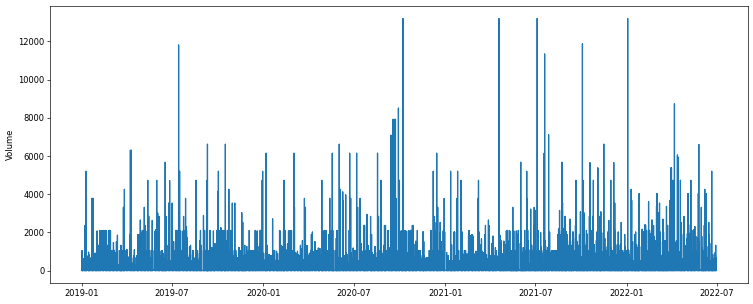

In [41]:

plt.figure(figsize=(15,6), dpi=60)
plt.plot(df3['date'], df3['volume_sold_liters'])
plt.ylabel('Volume (Liters)')
plt.show()


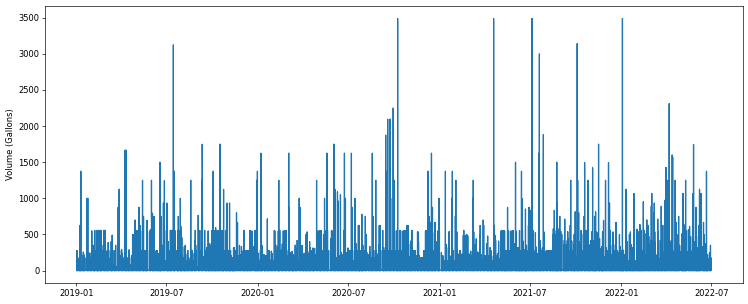

In [12]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df2['date'], df2['volume_sold_gallons'])
plt.ylabel('Volume (Gallons)')
plt.show()


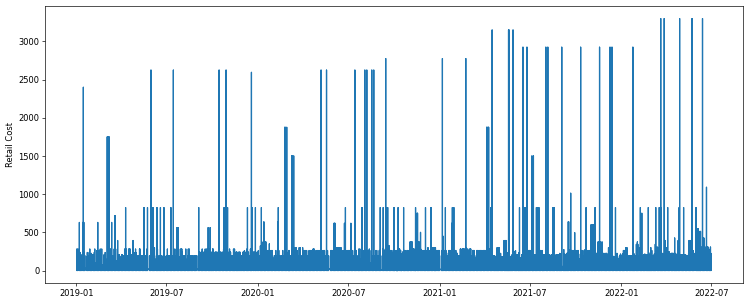

In [14]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df2['date'], df2['state_bottle_retail'])
plt.ylabel('Retail Cost')
plt.show()


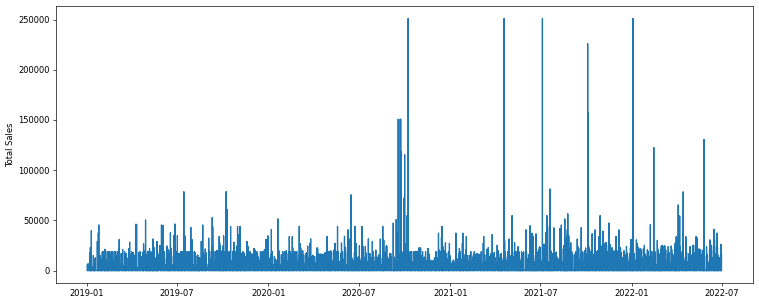

In [15]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df2['date'], df2['sale_dollars'])
plt.ylabel('Total Sales')
plt.show()

In [ ]:
'''
In order to harness the full power of the dataset some aggregations need to be done to process the data at scale.
Summations can be performed by date for metrics such as volume and sales which can drastically reduce the amount unnessary
detail in the data. Other processing can be done to aggregate data by county or by specific alcohol to
understand more details of the summations through a cross sectional time series analysis. There is a frequent occurance of 0
in the data that needs to be handled for daily forecasting. The visuals only show a small slice of the data.

Additional transformations may need to be performed to induce stationarity for statistical forecasting.

GARCH processes can be investigated to investigate more details on model variance as well

'''

In [45]:
df2 = df[['date','volume_sold_liters', 'volume_sold_gallons', 'state_bottle_retail', 'sale_dollars']]
df2.set_index('date',inplace=True)
df2.index = pd.to_datetime(df_liter.index)
df3 = df2.resample('W').sum()

In [46]:
df3.sort_values('date',ascending=True)

,volume_sold_liters,volume_sold_gallons,state_bottle_retail,sale_dollars
date,,,,
2019-01-06,232224.19,61176.82,486089.79,3617434.79
2019-01-13,345101.17,90950.39,610592.25,5217245.35
2019-01-20,346097.67,91213.17,614128.36,5172008.88
2019-01-27,323464.93,85251.95,565078.75,4726757.33
2019-02-03,358992.55,94598.30,658855.79,5352870.47
...,...,...,...,...
2022-06-05,425372.01,112100.13,848059.43,7429347.41
2022-06-12,473770.99,124867.96,924019.64,8299091.70
2022-06-19,480968.36,126758.03,964844.67,8887463.73


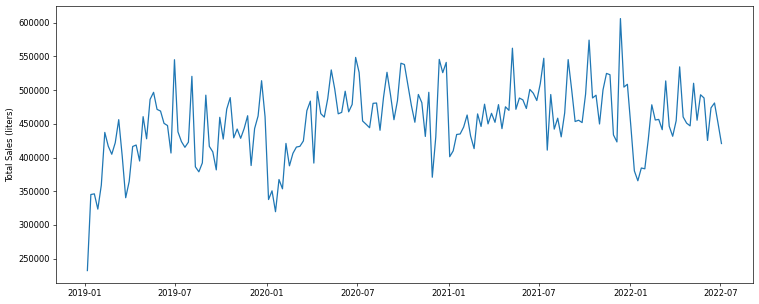

In [47]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df3['volume_sold_liters'])
plt.ylabel('Total Sales (liters)')
plt.show()

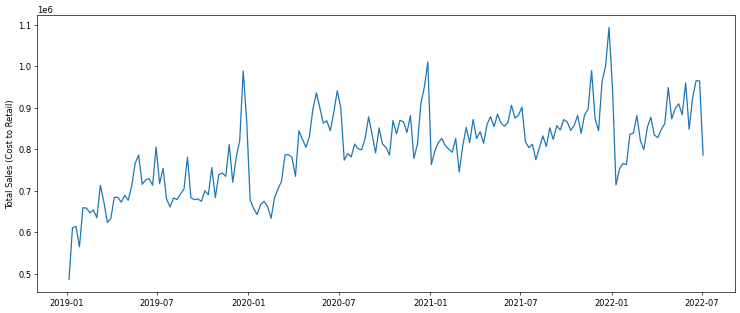

In [48]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df3['state_bottle_retail'])
plt.ylabel('Total Sales (Cost to Retail)')
plt.show()

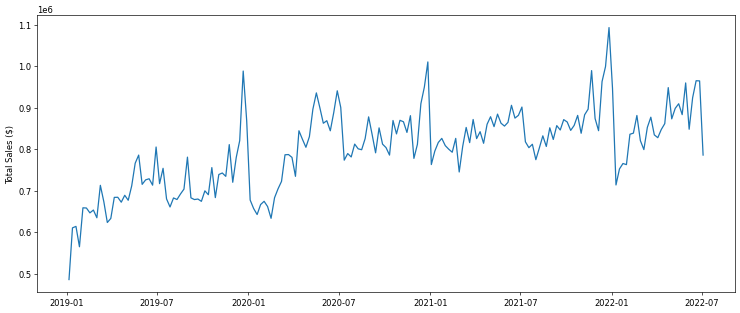

In [49]:
plt.figure(figsize=(15,6), dpi=60)
plt.plot(df3['state_bottle_retail'])
plt.ylabel('Total Sales ($)')
plt.show()